#### Las siguientes son Notas sacadas del Capítulo 6 del libro
    
    Validated Numerics: A Short Introduction to Rigorous Computations
    Warwick Tucker

En la sección $6.2$ lo que queremos es resolver el problema de valores iniciales (IVP):
\begin{equation}
    \left\{
        \begin{array}{ll}
            \dot{x}(t)=f(x(t)), \hspace{1cm} t \in [0,T'] \\
            x(0)=x_0.
        \end{array}
    \right.
\end{equation}

Esto implica que 
\begin{equation}
    x(t)=x_0 + \int_0^t f\left(x(s)\right)ds 
\end{equation}


Para lo cual partimos de suponer que conocemos una extensión de intervalo $\Psi$ talque $x(t) \in \Psi(t)$ para toda $t \in [0,T']$. Esto se puede traducir a que:

\begin{equation}
    x(t) \in x_0 + \int_0^t F\left(\Psi(s)\right)ds 
\end{equation}

Donde $F$ es la extensión de intervalo de $f$. Por lo que al final no debemos probar que $x(t) \in \Psi(t)$ sino que

\begin{equation}
    x_0 + \int_0^t F\left(\Psi(s)\right)ds \subseteq \Psi(t) , \hspace{1cm} t \in \left[0,T'\right]
\end{equation}

Cito textualmente:

    "If this condition holds, it follows by Brouwer’s fixed point theorem (Theorem A.12) that the enclosure Ψ(t) contains at least one fixed point of the integral operator (6.6). This means that it indeed encloses at least one solution to the IVP (6.4)."

Por otro lado esta condición tambien implica que $\Psi^{(k+1)} \subseteq \Psi^{(k)}$ donde los ordenes de las $\Psi$'s están dados por:

\begin{align}
    \Psi^{(0)}(t)&=\Psi(t) \\
    \Psi^{(k+1)}(t)&= x_0 + \int_0^t F\left(\Psi^{(k)}(s)\right)ds
\end{align}

En un punto de partida muy sencillo podemos suponer que vamos a tomar intervalos constantes $\Psi^{(k)}(t)=\mathbf{z}^{(k)}$. De modo que las $\mathbf{z}$'s anidadas sean:

\begin{equation}
    \mathbf{z}^{(k+1)}(t)= x_0 + \int_0^t F(\mathbf{z}^{(k)})ds = x_0 + \left[0,T'\right] \times F(\mathbf{z}^{(k)})
\end{equation}

Estos rectángulos son cotas demasiado grandes, podemos reducirlo a triángulos de modo que 

\begin{equation}
    x(t) \in x_0 + t F(\mathbf{z}^{(k)})
\end{equation}

In [1]:
using Images

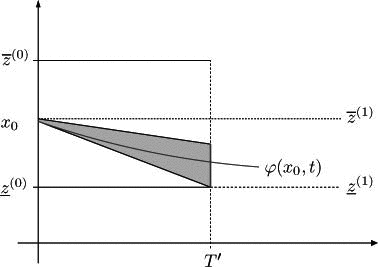

In [2]:
cadena="/home/santiago/Documentos/Libros/Fisica/Métodos Numéricos/Warwick_Tucker_Validated_Numerics_A_Short_IntroBookZZ.org.epub_FILES/OPS/images/f0109-01.jpg"
imread(cadena)

In [3]:
using PyPlot
using Intervalos

INFO: Loading help data...


SANTIAGO_001: creé función conosPunto y conosPuntoDiez, que grafica el primer cono

In [4]:
function conosPunto(tI,tF,x0::Intervalo,f::Function,x::Function)
    t=linspace(tI,tF,10)
    PyPlot.plot(t,x(t))
    
    z0=Intervalo[]
    z0Top=similar(t)
    z0Bot=similar(t)
    for i=1:length(t)
        push!(z0,3 + t[i]*f(x0))
        z0Top[i]=z0[i].b
        z0Bot[i]=z0[i].a
        PyPlot.plot(t[i]*[1,1],Float64[z0[i].a,z0[i].b],"--g")
    end
    
    PyPlot.plot(t,z0Top,"-r")
    PyPlot.plot(t,z0Bot,"-r");
    PyPlot.ylim([min(z0Bot[end],z0Bot[1],x(0),x(t[end]))-1,
        max(z0Bot[end],z0Bot[1],x(0),x(t[end]))+1]);
    return z0[end]
end

conosPunto (generic function with 1 method)

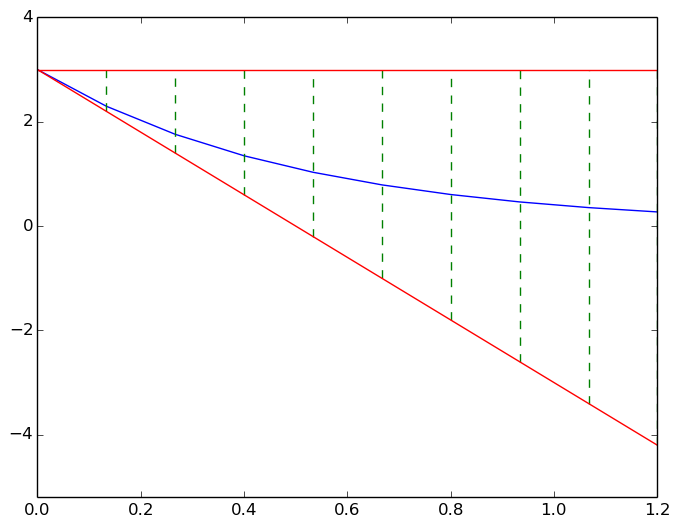

[-4.199999999999999733546474089962430298328399658203125e+00,
3e+00]

In [5]:
# d/dt x(t) = -2x(t) ; x(0)=3   →    x(t)= 3 exp(-2t)
f(x)= -2*x
x(t)=3*exp(-2*t)
conosPunto(0,1.2,Intervalo(0,3),f,x)

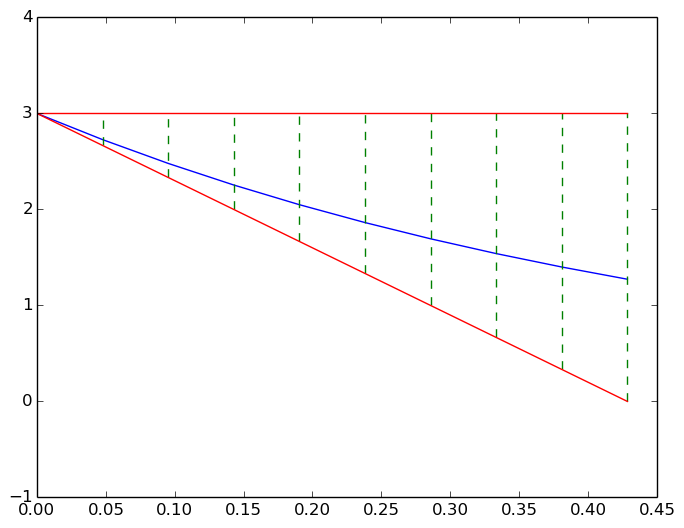

[1.66533453693773481063544750213623046875e-16,
3e+00]

In [23]:
# d/dt x(t) = -2x(t) ; x(0)=3   →    x(t)= 3 exp(-2t)
f(x)= -2*x
x(t)=3*exp(-2*t)
algo1=conosPunto(0,3/7,Intervalo(0,3.5),f,x)

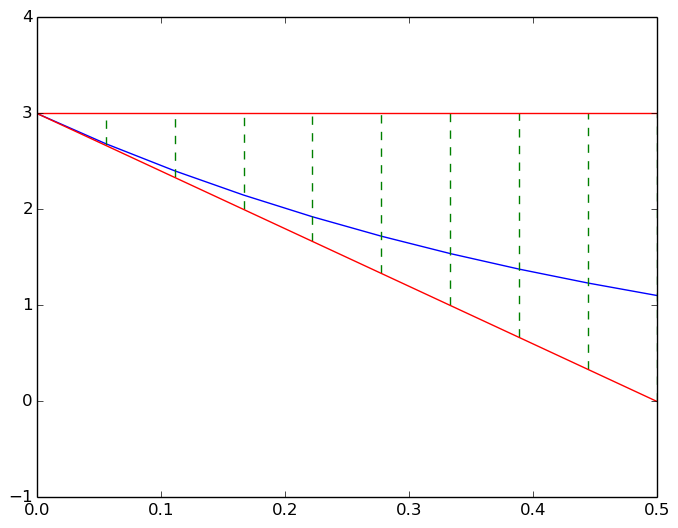

[-0e+00,
3e+00]

In [25]:
# d/dt x(t) = -2x(t) ; x(0)=3   →    x(t)= 3 exp(-2t)
f(x)= -2*x
x(t)=3*exp(-2*t)
conosPunto(0,0.5,Intervalo(0,3),f,x)

Ahora trataré de implementar los 'endpoints'

Primero defino algunas operaciones entre números, arreglos de números, Intervalos y arreglos de Intervalos 

In [6]:
function *(x::Vector{Int64},y::Intervalo)
    z=Intervalo[]
    for i=1:length(x)
        push!(z,x[i]*y)
    end
    return z
end
*(y::Intervalo,x::Vector{Int64})=*(x,y)
function *(x::Vector{Float64},y::Intervalo)
    z=Intervalo[]
    for i=1:length(x)
        push!(z,x[i]*y)
    end
    return z
end
*(y::Intervalo,x::Vector{Float64})=*(x,y)
function +(y::Array{Intervalo,1},x::Number)
    z=similar(y)
    for i=1:length(y)
        z[i]=y[i]+x
    end
    return z
end
+(x::Number,y::Array{Intervalo,1})=+(y,x)

+ (generic function with 185 methods)

Ahora defino funciones que me ayudan a visualizar (y entender) el método

In [7]:
function conosInterv(tI,tF,x0::Intervalo,f::Function,x::Function)
    #t=tI:2.0^-5:tF
    t=linspace(tI,tF,10)
    PyPlot.plot(t,x(t),color="blue")
    
    triple=[tI , t[integer(length(t)/2)] , tF]-tI
    #triplex0=[x0,x0,x0]
    #for i=1:length(temp)
    #    triplex0=triple[i]*x0
    #end
    cono0=x0.a + triple*f(x0)
    cono0Top=Float64[cono0[1].b,cono0[2].b,cono0[3].b]
    cono0Bot=Float64[cono0[1].a,cono0[2].a,cono0[3].a]
    PyPlot.plot(triple+tI,cono0Top,"--",color="red")
    PyPlot.plot(triple+tI,cono0Bot,"-",color="red")
    
    cono1=x0.b + triple*f(x0)
    cono1Top=Float64[cono1[1].b,cono1[2].b,cono1[3].b]
    cono1Bot=Float64[cono1[1].a,cono1[2].a,cono1[3].a]
    PyPlot.plot(triple+tI,cono1Top,"-",color="g")
    PyPlot.plot(triple+tI,cono1Bot,"--",color="g")
    
    PyPlot.ylim([min(cono0Bot[end],cono1Bot[end],cono0Bot[1],cono1Bot[1],x(tI),x(tF))-1,
        max(cono0Bot[end],cono1Bot[end],cono0Bot[1],cono1Bot[1],x(tI),x(tF))+1]);
    
    cono=uneconos(cono0,cono1)
    graficaListaInterv(triple+tI,cono)
    return cono[3]
end

function uneconos(conoA::Array{Intervalo,1},conoB::Array{Intervalo,1})
    # esta función toma dos arreglos de intervalos y los une aunque no se intersecten
    if length(conoA)!=length(conoB)
        error("Deben tener mismo tamaño")
    end
    if conoA[1].a≥conoB[1].a && conoA[end].a≥conoB[end].a
        bajo=conoB
        alto=conoA
    else
        bajo=conoA
        alto=conoB
    end
    cono=Intervalo[]
    for i=1:length(conoA)
        push!(cono,Intervalo((bajo[i]).a,(alto[i]).b))
    end
    return cono
end

function graficaListaInterv(lista::Array{Intervalo,1})
    # esta función grafica una lista de Intervalos
    for i=1:length(lista)
        PyPlot.plot([i,i],Float64[lista[i].a,lista[i].b],"-",color="black")
        #PyPlot.plot([i,i],Float64[lista[i].a,lista[i].b],"-")
    end
    PyPlot.xlim(0,length(lista)+1)
end

function graficaListaInterv(ejeX,lista::Array{Intervalo,1})
    # esta función grafica una lista de Intervalos, con dependencia en x con ejeX
    if length(ejeX)!=length(lista)
        error("Deben tener mismo tamaño")
    end
    for i=1:length(lista)
        PyPlot.plot(ejeX[i]*[1,1],Float64[lista[i].a,lista[i].b],"-",color="black")
        #PyPlot.plot([i,i],Float64[lista[i].a,lista[i].b],"-")
    end
    PyPlot.xlim(0.9*ejeX[1],1.1*ejeX[end])
end

graficaListaInterv (generic function with 2 methods)

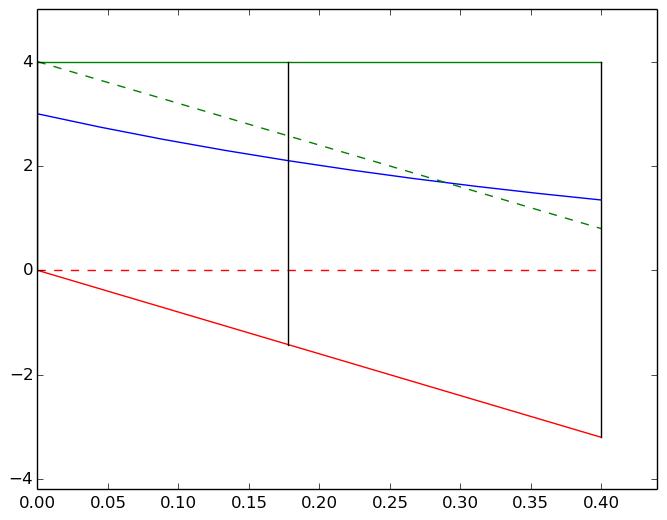

In [8]:
# d/dt x(t) = -2x(t) ; x(0)=3   →    x(t)= 3 exp(-2t)

a0=4
f(x)= -2*x
x(xo,t)=xo*exp(-2*t)
y(t)=x(3,t)

x1=conosInterv(0,0.4,Intervalo(0,4),f,y);

Entonces generé dos conos: conoV (verde) y conoR (rojo), y digo que $x(t)\in$conoV$\cup$conoR. Donde la unión inluye el espacio entre los intervalos, marcado en la gráfica como los intervalos de las líneas continuas (verde y roja). Las lineas negras son los tres intervalos que regresa la función `conosInterv`

Ahora debo aplicar lo de definir un nuevo intervalo para inicar generado por este cono (que será la última línea negra)

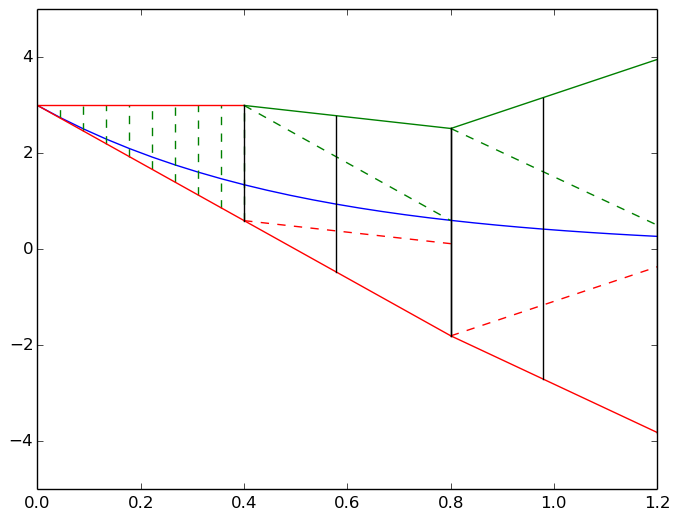

In [9]:
# d/dt x(t) = -2x(t) ; x(0)=3   →    x(t)= 3 exp(-2t)

a0=4
f(x)= -2*x
x(xo,t)=xo*exp(-2*t)
y(t)=x(3,t)

tT=1.2
tiempo=linspace(0,tT,4)

x1=conosPunto(tiempo[1],tiempo[2],Intervalo(0,3),f,y);
#agregué el siguiente renglón
x2=conosInterv(tiempo[2],tiempo[3],x1,f,y);
#agregué el siguiente renglón
conosInterv(tiempo[3],tiempo[4],x2,f,y);
PyPlot.xlim(0,tT)
PyPlot.ylim(-5,5);

Hay algo raro ya que debía disminuir el intervalo, no aumentar, con cada nueva partición. Si no sería mejor tomar una sola partición:

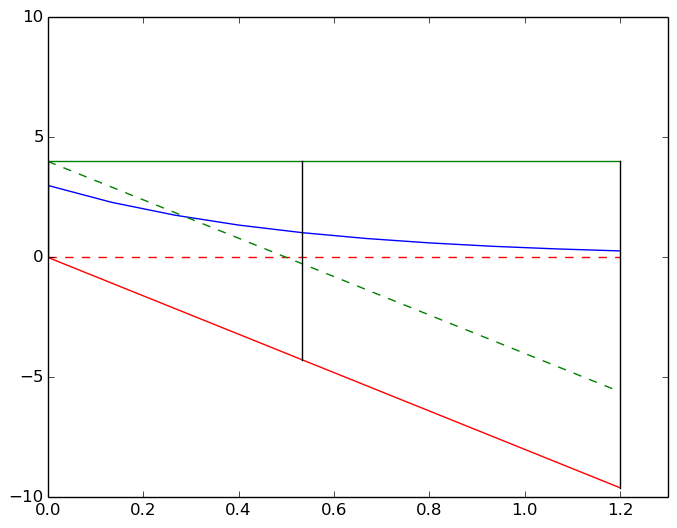

(-10,10)

In [8]:
# d/dt x(t) = -2x(t) ; x(0)=3   →    x(t)= 3 exp(-2t)

a0=4
f(x)= -2*x
x(xo,t)=xo*exp(-2*t)
y(t)=x(3,t)

conosInterv(0,1.2,Intervalo(0,4),f,y)[3];

PyPlot.xlim(0,1.3)
PyPlot.ylim(-10,10);

##Prueba
#t=linspace(0,1.2,10)
#PyPlot.plot(t,x(4,t),color="blue")
#PyPlot.plot(t,x(0,t),color="blue")
##Prueba

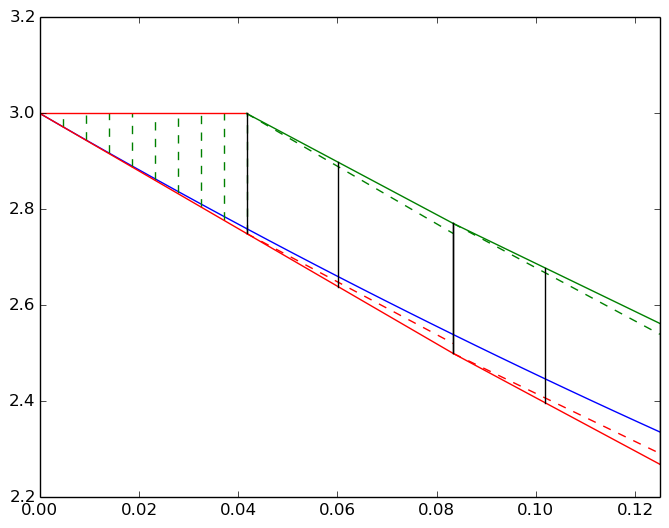

In [14]:
# d/dt x(t) = -2x(t) ; x(0)=3   →    x(t)= 3 exp(-2t)

a0=4
f(x)= -2*x
x(xo,t)=xo*exp(-2*t)
y(t)=x(3,t)

tT=0.125
tiempo=linspace(0,tT,4)

x1=conosPunto(tiempo[1],tiempo[2],Intervalo(0,3),f,y);
#agregué el siguiente renglón
x2=conosInterv(tiempo[2],tiempo[3],x1,f,y);
#agregué el siguiente renglón
x3=conosInterv(tiempo[3],tiempo[4],x2,f,y);
PyPlot.xlim(0,tT)
PyPlot.ylim(2.2,3.2);

In [18]:
x1
x2
#x3

[2.5000000000000000277555756156289135105907917022705078125e+00,
2.770833333333333344898156506512047360277161355520573357074264752830910617936722e+00]

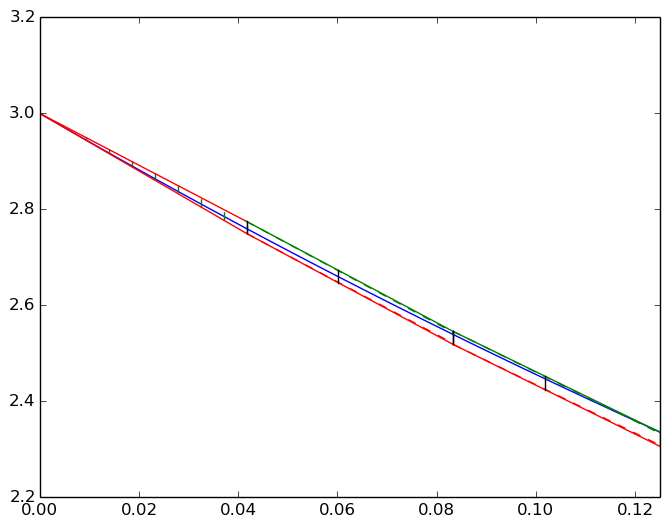

In [13]:
# d/dt x(t) = -2x(t) ; x(0)=3   →    x(t)= 3 exp(-2t)

a0=4
f(x)= -2*x
x(xo,t)=xo*exp(-2*t)
y(t)=x(3,t)

tT=0.125
tiempo=linspace(0,tT,4)

x1=conosPunto(tiempo[1],tiempo[2],Intervalo(2.7,3),f,y);
#agregué el siguiente renglón
x2=conosInterv(tiempo[2],tiempo[3],x1,f,y);
#agregué el siguiente renglón
x3=conosInterv(tiempo[3],tiempo[4],x2,f,y);
PyPlot.xlim(0,tT)
PyPlot.ylim(2.2,3.2);

#### A partir de aquí están las funciones que "creo" vamos a usar, las de arriba son solo guía

Santiago_001: Voy a definir las funciones para conocer $Z^k$'s, conociendo tiempo inicial, final, z0 (y # de k's).

También puse un límite para que se detenga si el intervalo ya no se reduce

In [45]:
function kaesimaZeta(tI,tF,x0,z0::Intervalo,f::Function,k::Int64)
    zetas=[z0]
    for i=1:k
        zk=zetasKas(tI,tF,x0,zetas[i],f)
        push!(zetas,zk)
    end
    return zetas
end

kaesimaZeta (generic function with 1 method)

In [50]:
function zetasKas(tI,tF,x0,z0::Intervalo,f::Function)  
    x0 + Intervalo(tI,tF)*f(z0)
end

function kaesimaZeta(tI,tF,x0,z0::Intervalo,f::Function,k::Int64)
    zetas=[z0]
    for i=1:k
        zk=zetasKas(tI,tF,x0,zetas[i],f)
        if zk==zetas[i]
            return zetas
        else
            push!(zetas,zk)
        end
    end
    return zetas
end

kaesimaZeta (generic function with 1 method)

In [99]:
asdf=kaesimaZeta(0,3/7,3,Intervalo(0,3.5),f,5)

3-element Array{Intervalo,1}:
 [0e+00,
3.5e+00]                                                   
 [1.66533453693773481063544750213623046875e-16,
3e+00]              
 [4.2857142857142871417153173752012662589550018310546875e-01,
3e+00]

Santiago_001: Voy a definir una función que me grafique el cono resultante para 'última' $Z^k$

In [114]:
function graficaCono(tI,tF,x0,zk::Intervalo)
    PyPlot.fill_between([tI,tF],[x0,float64(zk.a)],[x0,float64(zk.b)],color="lightblue")
    PyPlot.xlim(min(0.9*tI,1.1*tI),max(0.9*tF,1.1*tF))
    PyPlot.ylim(min(0.9*float64(zk.a),1.1*float64(zk.a)),max(0.9*float64(zk.b),1.1*float64(zk.b)))
    return nothing
end

graficaCono (generic function with 1 method)

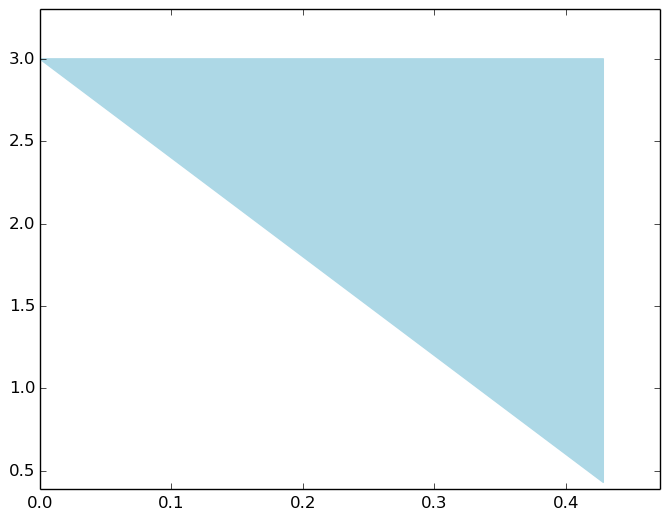

In [115]:
graficaCono(0,3/7,3,asdf[end])

In [354]:
x1

[-3.20000000000000017763568394002504646778106689453125e+00,
4e+00]

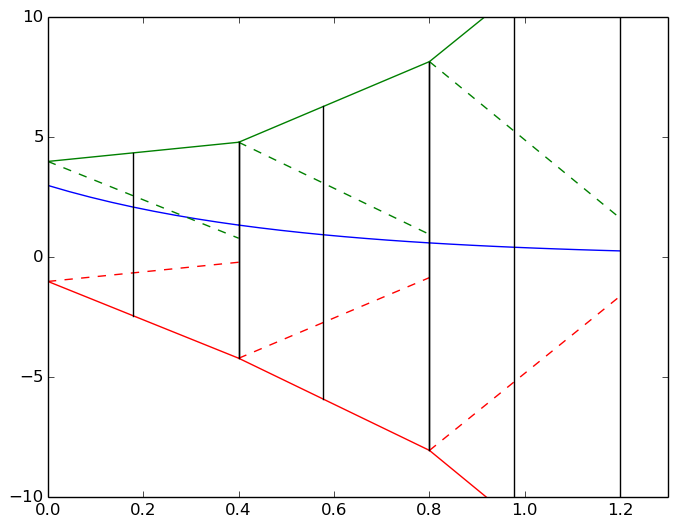

In [351]:
# d/dt x(t) = -2x(t) ; x(0)=3   →    x(t)= 3 exp(-2t)

a0=4
f(x)= -2*x
x(xo,t)=xo*exp(-2*t)
y(t)=x(3,t)

x1=conosInterv(0,0.4,Intervalo(-1,4),f,y)[3];
#agregué el siguiente renglón
x2=conosInterv(0.4,0.8,x1,f,y)[3];
#agregué el siguiente renglón
conosInterv(0.8,1.2,x2,f,y);
PyPlot.xlim(0,1.3)
PyPlot.ylim(-10,10);

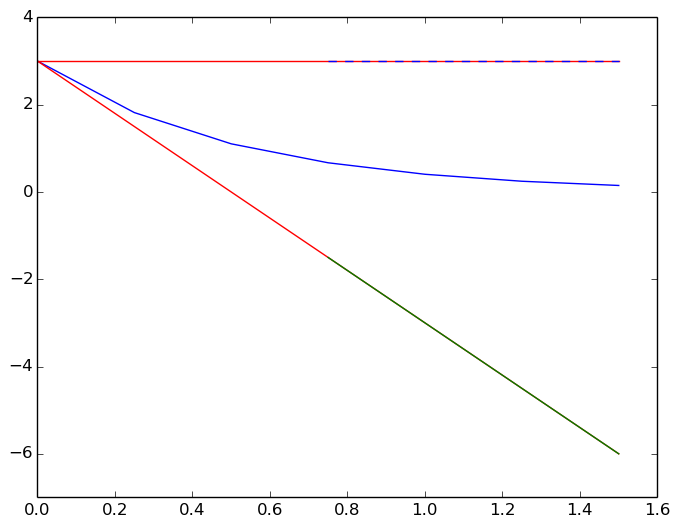

In [30]:
# d/dt x(t) = -2x(t) ; x(0)=3   →    x(t)= 3 exp(-2t)

a0=3
f(x)= -2*x
x(t)=a0*exp(-2*t)

t=0:2.0^-2:1.5
PyPlot.plot(t,x(t))


x0=[a0 + t[1]*f(Intervalo(0,a0)) , a0 + t[integer(length(t)/2)]*f(Intervalo(0,a0)) , a0 + t[end]*f(Intervalo(0,a0))]
x0Top=Float64[x0[1].b,x0[2].b,x0[3].b]
x0Bot=Float64[x0[1].a,x0[2].a,x0[3].a]
PyPlot.plot([t[1],t[integer(length(t)/2)],t[end]],x0Top,"-r")
PyPlot.plot([t[1],t[integer(length(t)/2)],t[end]],x0Bot,"-r")

x01=x0[2]
x1=[x01 + t[integer(length(t)/2)]t[1]*f(Intervalo(0,a0)) , x01 + t[integer(length(t)/2)]*f(Intervalo(0,a0))]
x1Top=Float64[x1[1].b,x1[2].b]
x1Bot=Float64[x1[1].a,x1[2].a]
PyPlot.plot([t[integer(length(t)/2)],t[end]],x1Top,"--b")
PyPlot.plot([t[integer(length(t)/2)],t[end]],x1Bot,"-",color="g")

PyPlot.ylim([min(x0Bot[end],x1Bot[end],x0Bot[1],x1Bot[1],x(0),x(t[end]))-1,
    max(x0Bot[end],x1Bot[end],x0Bot[1],x1Bot[1],x(0),x(t[end]))+1]);

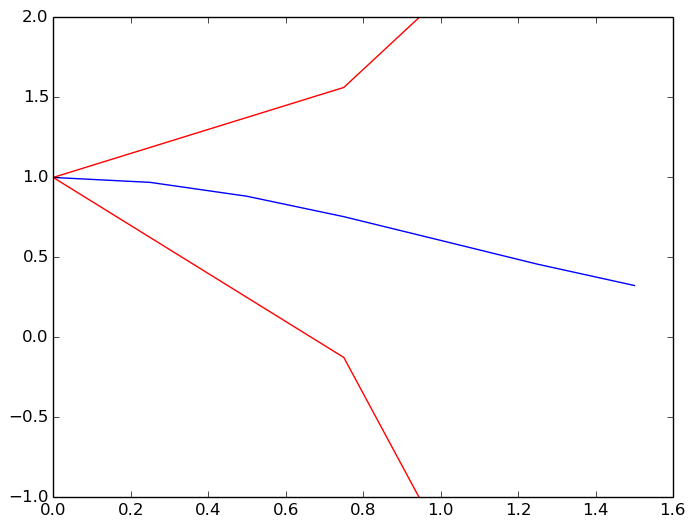

(-1.0,2.0)

In [5]:
# d/dt x(t) = -t x(t) ; x(0)=1   →    x(t)= a0 exp(-t^2 /2)

a0=1
i1=Intervalo(-1,2)

x(y)=a0*exp(-y.^2/2)
t=0:2.0^-2:1.5

PyPlot.plot(t,x(t))
# f(x)= -t x(t)
# t[i]*f(Intervalo(a,b))= - t[i]^2*Intervalo(a,b)

x0=[a0 - t[1]^2*i1 , a0 - t[integer(length(t)/2)]^2*i1 , a0 - t[end]^2*i1]
x0Top=Float64[x0[1].b,x0[2].b,x0[3].b]
x0Bot=Float64[x0[1].a,x0[2].a,x0[3].a]
PyPlot.plot([t[1],t[integer(length(t)/2)],t[end]],x0Top,"-r")
PyPlot.plot([t[1],t[integer(length(t)/2)],t[end]],x0Bot,"-r")
PyPlot.ylim(Float64[i1.a,i1.b])

#x01=x0[2]
#x1=[x01 + t[integer(length(t)/2)]t[1]*f(Intervalo(0,a0)) , x01 + t[integer(length(t)/2)]*f(Intervalo(0,a0))]
#x1Top=Float64[x1[1].b,x1[2].b]
#x1Bot=Float64[x1[1].a,x1[2].a]
#PyPlot.plot([t[integer(length(t)/2)],t[end]],x1Top,"-g")
#PyPlot.plot([t[integer(length(t)/2)],t[end]],x1Bot,"-g")



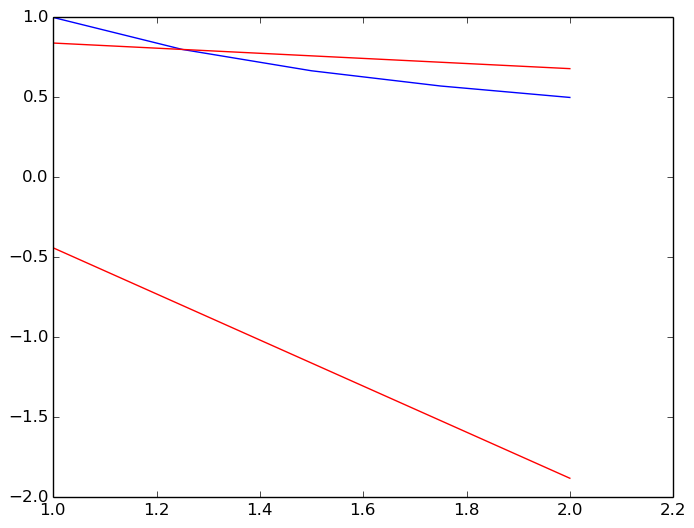

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5f27c9b310>

In [6]:
# d/dt x(t) = -(x(t))^2 /a0; x(1)=1   →    x(t)= a0/(t)

a0=1.0
i1=Intervalo(0.4,1.2)

f(x)= -(x)^2
x(y)=a0./y
t=1:2.0^-2:2

PyPlot.plot(t,x(t))

# t[i]*f(Intervalo(a,b))= - t[i]^2*Intervalo(a,b)

x0=[a0 + t[1]*f(i1) , a0 + t[integer(length(t)/2)]*f(i1) , a0 + t[end]*f(i1)]
x0Top=Float64[x0[1].b,x0[2].b,x0[3].b]
x0Bot=Float64[x0[1].a,x0[2].a,x0[3].a]
PyPlot.plot([t[1],t[integer(length(t)/2)],t[end]],x0Top,"-r")
PyPlot.plot([t[1],t[integer(length(t)/2)],t[end]],x0Bot,"-r")
#PyPlot.ylim(Float64[i1.a,i1.b])

#x01=x0[2]
#x1=[x01 + t[integer(length(t)/2)]t[1]*f(Intervalo(0,a0)) , x01 + t[integer(length(t)/2)]*f(Intervalo(0,a0))]
#x1Top=Float64[x1[1].b,x1[2].b]
#x1Bot=Float64[x1[1].a,x1[2].a]
#PyPlot.plot([t[integer(length(t)/2)],t[end]],x1Top,"-g")
#PyPlot.plot([t[integer(length(t)/2)],t[end]],x1Bot,"-g")



In [7]:
x0

3-element Array{Intervalo,1}:
 [-4.399999999999998934185896359849740914836229158107635293214132069655741830160878e-01,
8.399999999999999822364316059974948601838275474144966176696466982586064542459781e-01]
 [-1.159999999999999840127884453977461137225434373716145293982119810448361274524132e+00,
7.599999999999999733546474089962422902757413211217449265044700473879096813689671e-01]
 [-1.879999999999999786837179271969948182967245831621527058642826413931148366032176e+00,
6.799999999999999644728632119949897203676550948289932353392933965172129084919561e-01]